# Movie Runtime vs Revenue

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import requests

## Data Preparation & Filter

In [2]:
# Read data and filter movies with revenue
df = pd.read_csv('./data/movie.metadata.tsv', sep='\t', header=None, names=["wiki_id", "fb_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"])
df_meta = df[df['revenue'].notnull()]

In [3]:
# Filter for movies with runtime
df_runtime = df_meta[df_meta['runtime'].notnull()]

In [4]:
# IQR
Q1 = np.percentile(df_runtime['runtime'], 25)
Q3 = np.percentile(df_runtime['runtime'], 75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Remove outlier
df_runtime = df_runtime[(df_runtime['runtime'] >= lower) & (df_runtime['runtime'] <= upper)]
df_runtime.head(5)

,wiki_id,fb_id,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa..."
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""..."
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


## Runtime histogram

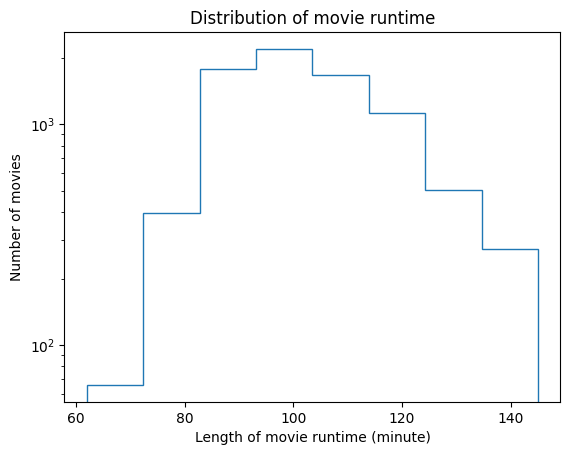

In [5]:
# histogram plot
plt.hist(df_runtime['runtime'], histtype="step", log=True, bins=8)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()

## Regression Analysis (runtime w.r.t revenue)

In [6]:
runtime_model = smf.ols("revenue ~ runtime", data=df_runtime).fit()

# summarize our model
runtime_model_summary = runtime_model.summary()
runtime_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     315.0
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           3.77e-69
Time:                        03:09:22   Log-Likelihood:            -1.5814e+05
No. Observations:                7990   AIC:                         3.163e+05
Df Residuals:                    7988   BIC:                         3.163e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -8.63e+07   7.46e+06    -11.568      0.000   -1.01e+08   -7.17e+07
runtime     1.269e+06   7.15e+04     17.748      0.000    1.13e+06    1.41e+06
==============================================================================
Omnibus:                     7859.716   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           425842.919
Skew:                           4.835   Prob(JB):                         0.00
Kurtosis:                      37.433   Cond. No.                         729.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see from the result, both R squared and adjusted R squared are 0.038 which is small to justify for dependency between the two variables.

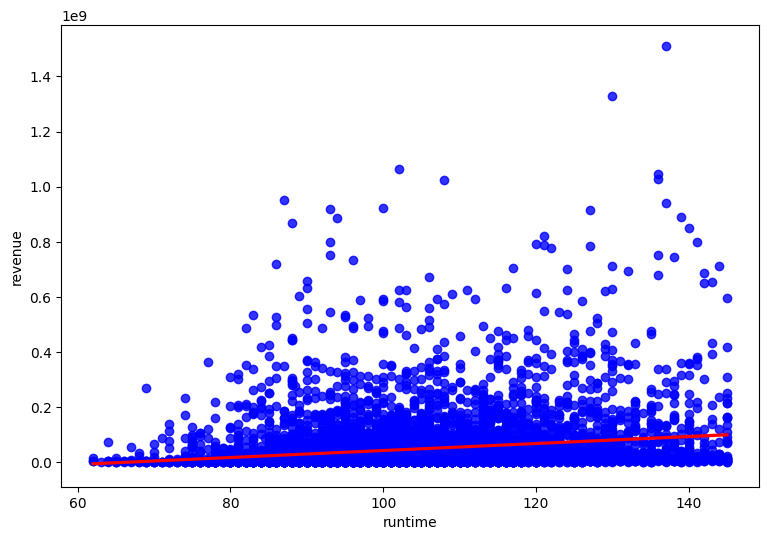

In [7]:
fig = plt.figure(figsize=(9,6))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sns.regplot(x='runtime', y='revenue', data=df_runtime, ci=95, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

## Blockbuster vs Non-blockbuster

In [8]:
df_bb = df_runtime[df_runtime['revenue'] >= 400000000]
df_non_bb = df_runtime[df_runtime['revenue'] < 400000000]

In [9]:
# independent t-test
stats.ttest_ind(a=df_bb['runtime'], b=df_non_bb['runtime'], equal_var=False)

Ttest_indResult(statistic=6.492688211532659, pvalue=1.805738120166336e-09)

In [10]:
# calculate mean difference
mean_diff = df_bb['runtime'].mean() - df_non_bb['runtime'].mean()

# print the mean difference
print(f"The mean difference in runtime is: {mean_diff}")

The mean difference in runtime is: 10.390489758081785


In [11]:
# calculating the percentage difference in runtime between the mean and non-blockbuster
diff_percent = mean_diff / df_non_bb["runtime"].mean()

# printing the results
diff_percent

0.10080716900752903

The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
Further, the mean difference tells us that the blockbuster runtime is generally longer than non-blockbuster.  
We can conclude that longer runtime are more successful as blockbuster movies have 10.08% longer runtime than non-blockbuster movies. 

# Plot Summary vs Revenue

## Data Preparation & Filtering

In [12]:
df_summary = pd.read_csv('./data/plot_summaries.txt', sep="\t", header=None, names=["wiki_id", "summary"])
df_summary = df_summary[df_summary['summary'].notnull()]

In [13]:
df_merge = pd.merge(df_meta,df_summary,on=['wiki_id'], how='inner')
df_merge = df_merge[["wiki_id", "summary", "revenue"]]
df_merge.head(5)

,wiki_id,summary,revenue
0,975900,"Set in the second half of the 22nd century, th...",14010832.0
1,171005,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,10161099.0
2,77856,The film opens with Mary Poppins perched in a...,102272727.0
3,156558,A young 20-year-old named Jody lives with his...,29381649.0
4,261237,The film is a collision of three separate stor...,34331783.0


## Positive/Negative/Violent Word List

In [14]:
# collecting the positive words list

# requesting the url
r = requests.get("https://ptrckprry.com/course/ssd/data/positive-words.txt")

# extracting and decoding the content from the request
text = r.content.decode("us-ascii")

# extracting the text containing the positive words
pos_text = text.split("\n\n")

# converting the text into a list
pos_list = pos_text[1].split("\n")

In [15]:
# collecting the neagative words list

# requesting the url
r = requests.get("https://ptrckprry.com/course/ssd/data/negative-words.txt")

# extracting and decoding the content from the request
text = r.content.decode("iso-8859-1")

# extracting the text containing the negative words
neg_text = text.split("\n\n")

# converting the text into a list
neg_list = neg_text[1].split("\n")

In [17]:
# collecting the violence words list
# source: https://myvocabulary.com/word-list/violence-vocabulary/

# Read from txt file
violent_file = open("./data/violent_word_list.txt", "r")
violent_words = violent_file.read()

# Split into list
vio_list = violent_words.split(', ')

# Map every word into lower case
vio_list = list(map(lambda x: x.lower(), vio_list))

In [18]:
# creating a function for pronoun indication
def check_summary(summary, list_):
    """
    Count how many words the summary contains from a given list 

    Parameters
    ----------
    summary: string
        The summary you desire to check
    list_: array
        The list to do look up in

    Returns
    -------
    int
        Count of words contained from given list
    """
    cnt = 0
    for word in summary.lower().split():
        if word in list_:
            cnt += 1
    return cnt

In [19]:
# adding column for positive sentiment
df_merge["positive"] = df_merge["summary"].apply(
    lambda x: check_summary(x, pos_list)
)

# adding a columns for negative sentiment
df_merge["negative"] = df_merge["summary"].apply(
    lambda x: check_summary(x, neg_list)
)

# adding a columns for violent sentiment
df_merge["violent"] = df_merge["summary"].apply(
    lambda x: check_summary(x, vio_list)
)

In [20]:
df_merge.head(5)

,wiki_id,summary,revenue,positive,negative,violent
0,975900,"Set in the second half of the 22nd century, th...",14010832.0,2,16,12
1,171005,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,10161099.0,1,1,0
2,77856,The film opens with Mary Poppins perched in a...,102272727.0,26,33,9
3,156558,A young 20-year-old named Jody lives with his...,29381649.0,5,21,4
4,261237,The film is a collision of three separate stor...,34331783.0,9,19,10


In [21]:
# Sentiment List
sentiment = ['positive', 'negative', 'violent']

## Linear Regression (# of sentiment w.r.t revenue)

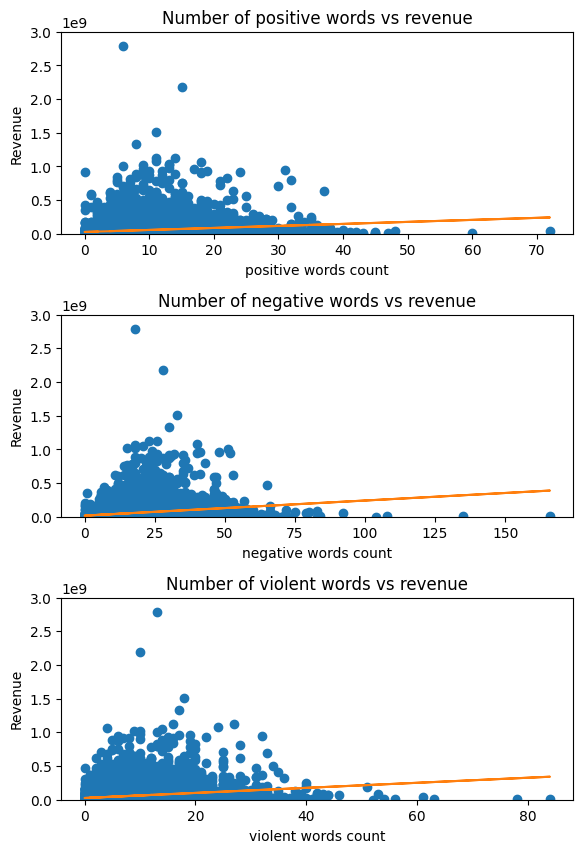

In [22]:
fig, ax = plt.subplots(3, 1)
# sentiment to ax position mapping
sen2ax = {
    'positive': ax[0],
    'negative': ax[1],
    'violent': ax[2]
}

for s in sentiment:
    ax = sen2ax[s]
    ax.plot(df_merge[s], df_merge['revenue'], 'o')
    
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(df_merge[s], df_merge['revenue'], 1)
    #add linear regression line to scatterplot 
    ax.plot(df_merge[s], m*df_merge[s]+b)
    
    ax.set_title('Number of ' + s + ' words vs revenue')
    ax.set_xlabel(s + ' words count')
    ax.set_ylabel("Revenue")
    ax.set_ylim(0, 3000000000)

# Combine all the operations and display
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1.7, wspace=0.4, hspace=0.4)
plt.show()

#sns.lmplot(x='positive', y='revenue', data=df_merge)

In [23]:
positive_revenue_model = smf.ols("revenue ~ positive", data=df_merge).fit()
positive_revenue_model_summary = positive_revenue_model.summary()
positive_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     218.9
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           7.60e-49
Time:                        03:15:53   Log-Likelihood:            -1.5159e+05
No. Observations:                7587   AIC:                         3.032e+05
Df Residuals:                    7585   BIC:                         3.032e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.769e+07    2.1e+06     13.209      0.000    2.36e+07    3.18e+07
positive    2.991e+06   2.02e+05     14.794      0.000    2.59e+06    3.39e+06
==============================================================================
Omnibus:                     9349.907   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2117186.865
Skew:                           6.499   Prob(JB):                         0.00
Kurtosis:                      83.798   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
negative_revenue_model = smf.ols("revenue ~ negative", data=df_merge).fit()
negative_revenue_model_summary = negative_revenue_model.summary()
negative_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     417.3
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           2.51e-90
Time:                        03:15:53   Log-Likelihood:            -1.5149e+05
No. Observations:                7587   AIC:                         3.030e+05
Df Residuals:                    7585   BIC:                         3.030e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.71e+07   2.14e+06      7.987      0.000    1.29e+07    2.13e+07
negative     2.24e+06    1.1e+05     20.427      0.000    2.02e+06    2.45e+06
==============================================================================
Omnibus:                     9337.622   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2189292.865
Skew:                           6.467   Prob(JB):                         0.00
Kurtosis:                      85.208   Cond. No.                         32.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
violence_revenue_model = smf.ols("revenue ~ violent", data=df_merge).fit()
violence_revenue_model_summary = violence_revenue_model.summary()
violence_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     412.1
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           2.90e-89
Time:                        03:15:54   Log-Likelihood:            -1.5149e+05
No. Observations:                7587   AIC:                         3.030e+05
Df Residuals:                    7585   BIC:                         3.030e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.572e+07   1.83e+06     14.057      0.000    2.21e+07    2.93e+07
violent     3.758e+06   1.85e+05     20.300      0.000     3.4e+06    4.12e+06
==============================================================================
Omnibus:                     9312.615   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2149582.743
Skew:                           6.440   Prob(JB):                         0.00
Kurtosis:                      84.449   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Blockbuster vs Non-blockbuster

In [26]:
df_bb = df_merge[df_merge['revenue'] >= 400000000]
df_non_bb = df_merge[df_merge['revenue'] < 400000000]

In [27]:
for s in sentiment:
    # independent t-test
    print(stats.ttest_ind(a=df_bb[s], b=df_non_bb[s], equal_var=False))

    # calculate mean difference
    mean_diff = df_bb[s].mean() - df_non_bb[s].mean()

    # print the mean difference
    print(f"The mean difference in number of {s} words in summary is: {mean_diff}")

    # calculating the percentage difference between the mean and non-blockbuster
    diff_percent = mean_diff / df_non_bb[s].mean()
    
    # printing the results
    print(f"The percentage difference in number of {s} words in summary between mean and non-blockbuster is: {diff_percent * 100}%\n")

Ttest_indResult(statistic=6.280640159427553, pvalue=3.1647305637476035e-09)
The mean difference in number of positive words in summary is: 3.4280695855307393
The percentage difference in number of positive words in summary between mean and non-blockbuster is: 42.95920675614537%

Ttest_indResult(statistic=11.989274111113305, pvalue=4.933709367707735e-24)
The mean difference in number of negative words in summary is: 9.832487700421193
The percentage difference in number of negative words in summary between mean and non-blockbuster is: 64.35146040794314%

Ttest_indResult(statistic=10.594407997580092, pvalue=4.006588639942095e-20)
The mean difference in number of violent words in summary is: 6.208853927016601
The percentage difference in number of violent words in summary between mean and non-blockbuster is: 91.24892063128766%



#### positive
The independent t-test for positive words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
Further, the mean difference tells us that blockbuster movies generally has more positive words in summary than non-blockbuster.  
We can conclude that more positive plot components are more successful as blockbuster movies have 42.96% more positive word usage than non-blockbuster movies. 

#### negative
The independent t-test for negative words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
Further, the mean difference tells us that blockbuster movies generally has more negative words in summary than non-blockbuster.  
We can conclude that more negative plot components are more successful as blockbuster movies have 64.35% more negative word usage than non-blockbuster movies. 

#### violent
The independent t-test for violent words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
Further, the mean difference tells us that blockbuster movies generally has more violent words in summary than non-blockbuster.  
We can conclude that more violent plot components are more successful as blockbuster movies have 91.25% more negative word usage than non-blockbuster movies. 